In [46]:
import utils.dataloader as dataloader
import os
import numpy as np
import xarray as xr
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import subprocess

# IITM

In [76]:
obs = "IMD" 
model = "IITM"
domain = [67, 98.5, 7, 38.5]  # West East South North, for Unet's check that lat and lot make a square divisible by 8, ie 24x24, 32x32, 64x64
season = "May-Sep"
n_bootstraps = 10
years = (2003,2018)
#matching years 2003-2018

In [77]:
download = False
if download:
    os.makedirs(f'download/{model}_{obs}', exist_ok=True)
os.makedirs(f'models/{model}_{obs}', exist_ok=True)
os.makedirs(f'figures/{model}_{obs}', exist_ok=True)
os.makedirs('outputs',exist_ok=True)

In [78]:
x_week1, y_week1 = dataloader.get_data(years=years, download = download,
                           week="wk1",obs=obs,
                            domain=domain, season=season, 
                           model=model, regrid=1)
y_week1 = y_week1.assign_coords(S=('T', x_week1['S'].values))                           

In [79]:
x_week2, y_week2 = dataloader.get_data(years=years, download = download,
                           week="wk2",obs=obs,
                            domain=domain, season=season, 
                           model=model, regrid=1)
y_week2 = y_week2.assign_coords(S=('T', x_week2['S'].values)) 

In [80]:
x_week3, y_week3 = dataloader.get_data(years=years, download = download,
                           week="wk3",obs=obs,
                            domain=domain, season=season, custom_lead = (16,22) ,
                           model=model, regrid=1)
y_week3 = y_week3.assign_coords(S=('T', x_week3['S'].values)) 

In [81]:
x_week4, y_week4 = dataloader.get_data(years=years, download = download,
                           week="wk4",obs=obs,
                            domain=domain, season=season, custom_lead = (23,29) ,
                           model=model, regrid=1)
y_week4 = y_week4.assign_coords(S=('T', x_week4['S'].values)) 

In [82]:
x_week34, y_week34 = dataloader.get_data(years=years, download = download,week="wk3-4", obs=obs, domain=domain, season=season, 
                           model=model, regrid=1)
y_week34 = y_week34.assign_coords(S=('T', x_week34['S'].values)) 


## Climatology

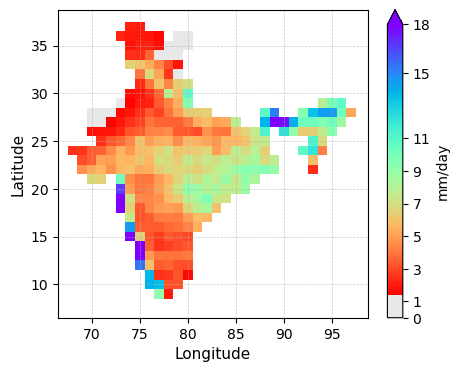

In [83]:
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust figure size and resolution
# Custom colorbar ticks and settings
ticks = [0, 1, 3, 5, 7, 9, 11, 15, 18]
cbar_kwargs = {
    'label': 'mm/day',
    'spacing': 'proportional',
    'format': '%.0f',  # No decimal values
    'ticks': ticks
}

# Use a custom colormap starting from light gray and transitioning through rainbow
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

# Create a new colormap that starts with light gray
n_colors = 256
rainbow = cm.get_cmap('rainbow_r', n_colors)
gray_to_rainbow = np.vstack((np.ones((20, 4)) * 0.9, rainbow(np.linspace(0, 1, n_colors - 20))))
custom_cmap = ListedColormap(gray_to_rainbow)

y_mmday = y_week34.mean('T')

y_mmday.plot(
    vmin=0, vmax=18, cmap=custom_cmap,
    cbar_kwargs=cbar_kwargs, ax=ax
)

ax.set_xlabel("Longitude", fontsize=11)
ax.set_ylabel("Latitude", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.savefig(f'figures/{model}_{obs}/climo_obs.pdf', dpi=300, bbox_inches='tight')

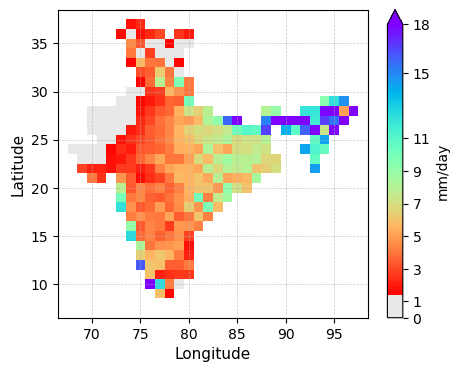

In [54]:
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust figure size and resolution
# Custom colorbar ticks and settings
ticks = [0, 1, 3, 5, 7, 9, 11, 15, 18]
cbar_kwargs = {
    'label': 'mm/day',
    'spacing': 'proportional',
    'format': '%.0f',  # No decimal values
    'ticks': ticks
}

# Use a custom colormap starting from light gray and transitioning through rainbow
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

# Create a new colormap that starts with light gray
n_colors = 256
rainbow = cm.get_cmap('rainbow_r', n_colors)
gray_to_rainbow = np.vstack((np.ones((20, 4)) * 0.9, rainbow(np.linspace(0, 1, n_colors - 20))))
custom_cmap = ListedColormap(gray_to_rainbow)

x_mmday = x_week34.mean('M').mean('T')
y_mask = y_week34.mean('T').isnull()
x_mmday = x_mmday.where(y_mask == 0, drop=False)
x_mmday.plot(
    vmin=0, vmax=18, cmap=custom_cmap,
    cbar_kwargs=cbar_kwargs, ax=ax
)

ax.set_xlabel("Longitude", fontsize=11)
ax.set_ylabel("Latitude", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.savefig(f'figures/{model}_{obs}/climo.pdf', dpi=300, bbox_inches='tight')

## ACC

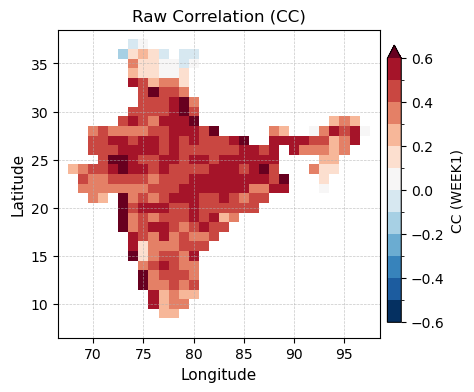

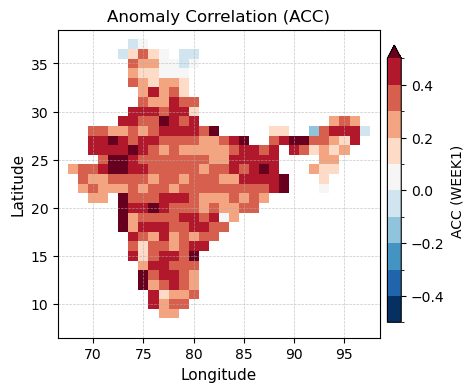

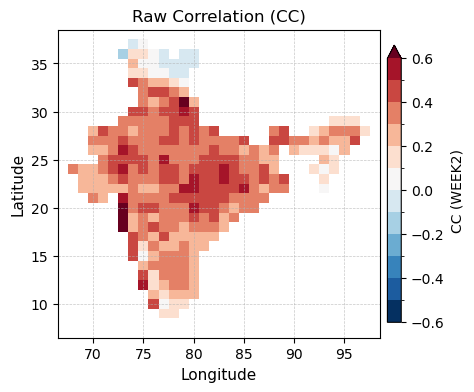

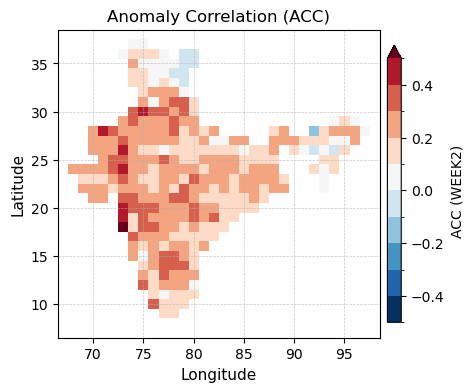

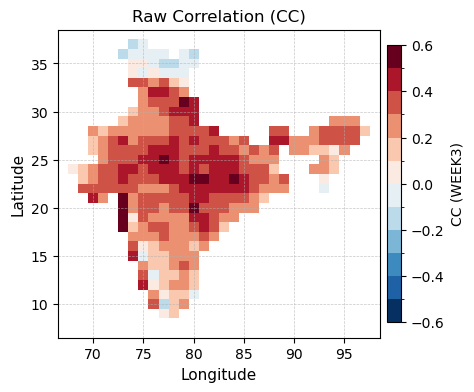

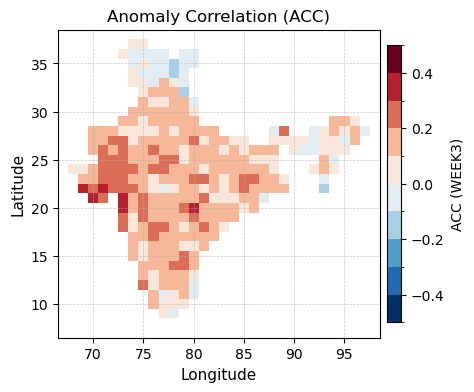

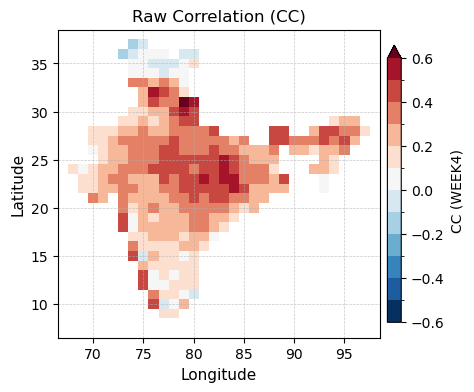

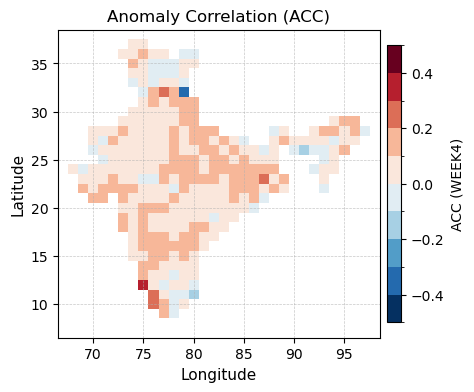

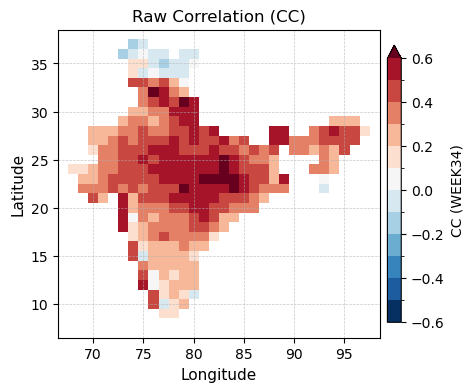

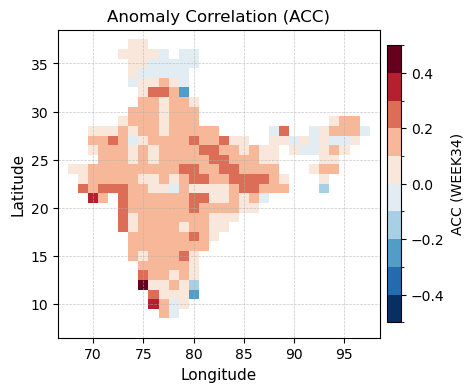

In [55]:
# Forecasts and observations by lead week
x_weeks = {
    "week1": x_week1,
    "week2": x_week2,
    "week3": x_week3,
    "week4": x_week4,
    "week34": x_week34
}

y_weeks = {
    "week1": y_week1,
    "week2": y_week2,
    "week3": y_week3,
    "week4": y_week4,
    "week34": y_week34
}

for week_name in x_weeks:
    x = x_weeks[week_name].mean('M')
    y = y_weeks[week_name]

    x_anom_list = []
    y_anom_list = []

    for week_i in set(x['S'].dt.week.values):
        # Subset by week number
        x_week_i = x.where(x['S'].dt.isocalendar().week == week_i, drop=True)
        y_week_i = y.where(y['S'].dt.isocalendar().week== week_i, drop=True)

        # Use y mean for anomaly computation
        y_week_anom = y_week_i - y_week_i.mean('T')
        x_week_anom = x_week_i - x_week_i.mean('T')

        x_anom_list.append(x_week_anom)
        y_anom_list.append(y_week_anom)

    # Merge across week subsets
    x_anom = xr.merge(x_anom_list)['prcp'].sortby('T')
    y_anom = xr.merge(y_anom_list)['prcp'].sortby('T')


    # Compute anomaly correlation coefficient
    cc = xr.corr(x, y, dim='T')
    acc = xr.corr(x_anom, y_anom, dim='T')

    # Plotting
    # --- Plot CC ---
    fig, ax = plt.subplots(figsize=(5, 4))
    cc.plot(
        ax=ax,
        vmin=-0.4, vmax=0.4, cmap='RdBu_r',
        levels=[ -0.6, -0.5,-0.4,-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
        cbar_kwargs={
            'label': f'CC ({week_name.upper()})',
            'shrink': 0.9, 'pad': 0.02, 'orientation': 'vertical'
        }
    )
    ax.set_title("Raw Correlation (CC)", fontsize=12)
    ax.set_xlabel("Longitude", fontsize=11)
    ax.set_ylabel("Latitude", fontsize=11)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(f'figures/{model}_{obs}/CC_{week_name}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # --- Plot ACC ---
    fig, ax = plt.subplots(figsize=(5, 4))
    acc.plot(
        ax=ax,
        vmin=-0.4, vmax=0.4, cmap='RdBu_r',
        levels=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
        cbar_kwargs={
            'label': f'ACC ({week_name.upper()})',
            'shrink': 0.9, 'pad': 0.02, 'orientation': 'vertical'
        }
    )
    ax.set_title("Anomaly Correlation (ACC)", fontsize=12)
    ax.set_xlabel("Longitude", fontsize=11)
    ax.set_ylabel("Latitude", fontsize=11)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(f'figures/{model}_{obs}/ACC_{week_name}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# ECMWF

In [56]:
obs = "IMD"
model = "ECMWF"
domain = [66, 100, 7, 39] # west east south north. for Unet's check that lat and lot make a square divisible by 8, ie 24x24, 32x32, 64x64
season = "May-Sep"
n_bootstraps = 10
years = (2003, 2018) #ECMWF hindcast range 20 years, behind the forecats year. Here we want a forecast year of 2023 so we use 2003-2022

In [57]:
download = False
if download:
    os.makedirs(f'download/{model}_{obs}', exist_ok=True)
os.makedirs(f'models/{model}_{obs}', exist_ok=True)
os.makedirs(f'figures/{model}_{obs}', exist_ok=True)
os.makedirs('outputs',exist_ok=True)

In [58]:
x_week1, y_week1 = dataloader.get_data(years=years, download = download,week="wk1", custom_lead=(2,9), obs=obs, domain=domain, season=season, 
                           model=model, regrid=1)

In [59]:
x_week2, y_week2 = dataloader.get_data(years=years, download = download,week="wk2",custom_lead=(9,16), obs=obs, domain=domain, season=season, 
                           model=model, regrid=1)

In [60]:
x_week3, y_week3 = dataloader.get_data(years=years, download = download,week="wk3", obs=obs, domain=domain, season=season, 
                           model=model, regrid=1, custom_lead = (16,22))

In [61]:
x_week4, y_week4 = dataloader.get_data(years=years, download = download,week="wk4", obs=obs, domain=domain, season=season, 
                           model=model, regrid=1, custom_lead = (23,30))

In [62]:
x_week34, y_week34 = dataloader.get_data(years=years, download = download,week="wk3-4", custom_lead=(16,30), obs=obs, domain=domain, season=season, 
                           model=model, regrid=1)

## Climatology

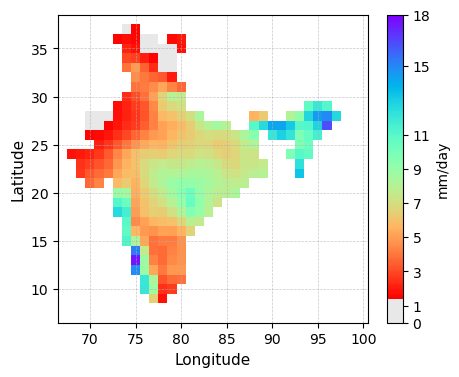

In [63]:
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust figure size and resolution
# Custom colorbar ticks and settings
ticks = [0, 1, 3, 5, 7, 9, 11, 15, 18]
cbar_kwargs = {
    'label': 'mm/day',
    'spacing': 'proportional',
    'format': '%.0f',  # No decimal values
    'ticks': ticks
}

# Use a custom colormap starting from light gray and transitioning through rainbow
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

# Create a new colormap that starts with light gray
n_colors = 256
rainbow = cm.get_cmap('rainbow_r', n_colors)
gray_to_rainbow = np.vstack((np.ones((20, 4)) * 0.9, rainbow(np.linspace(0, 1, n_colors - 20))))
custom_cmap = ListedColormap(gray_to_rainbow)

x_mmday = x_week34.mean('M').mean('T')/14
y_mask = y_week34.mean('T').isnull()
x_mmday = x_mmday.where(y_mask == 0, drop=False)
x_mmday.plot(
    vmin=0, vmax=18, cmap=custom_cmap,
    cbar_kwargs=cbar_kwargs, ax=ax
)

ax.set_xlabel("Longitude", fontsize=11)
ax.set_ylabel("Latitude", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.savefig(f'figures/{model}_{obs}/climo.pdf', dpi=300, bbox_inches='tight')

## ACC

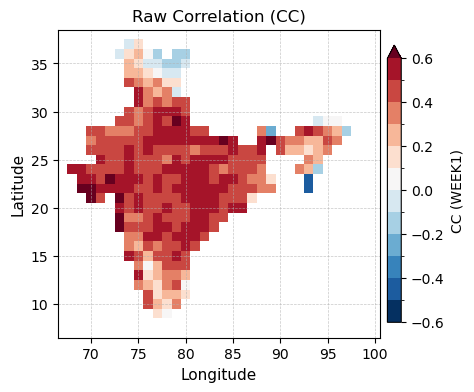

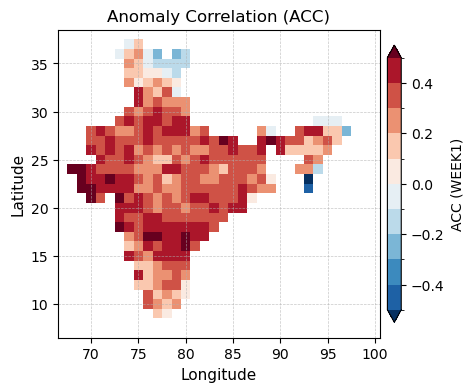

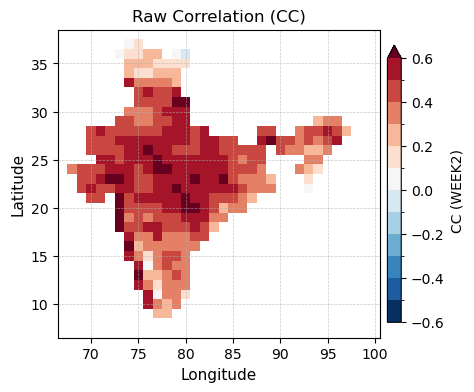

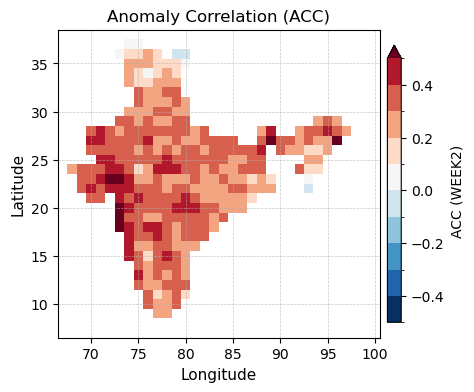

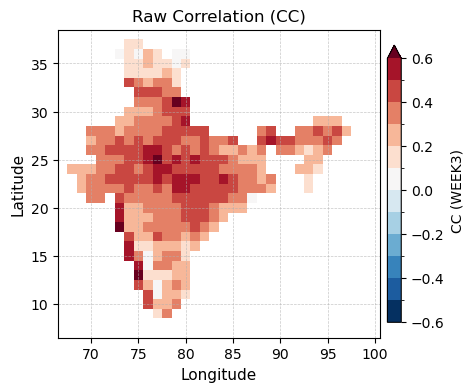

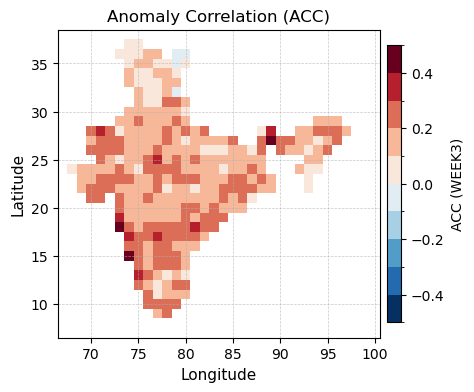

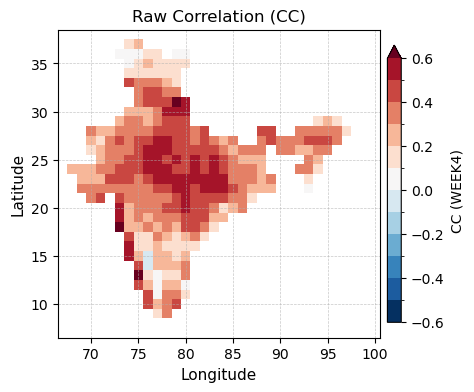

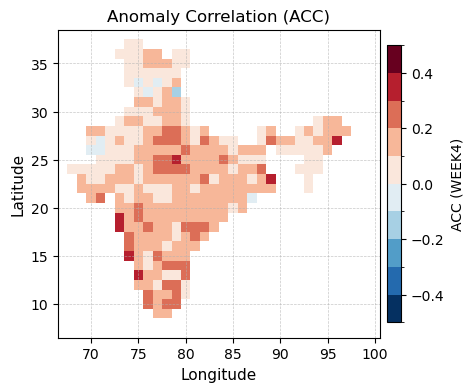

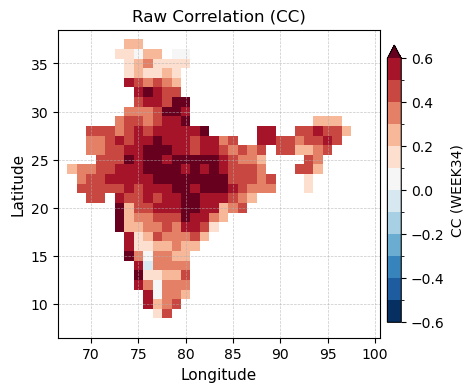

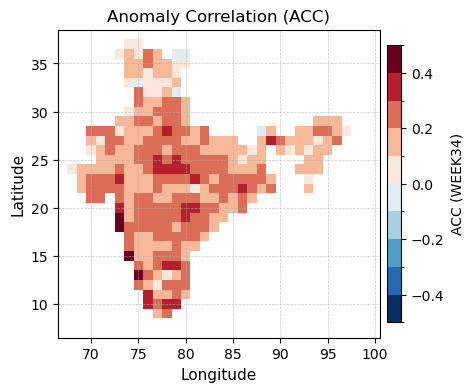

In [64]:
# Forecasts and observations by lead week
x_weeks = {
    "week1": x_week1,
    "week2": x_week2,
    "week3": x_week3,
    "week4": x_week4,
    "week34": x_week34
}

y_weeks = {
    "week1": y_week1,
    "week2": y_week2,
    "week3": y_week3,
    "week4": y_week4,
    "week34": y_week34
}

for week_name in x_weeks:
    x = x_weeks[week_name].mean('M')
    y = y_weeks[week_name]

    x_anom_list = []
    y_anom_list = []

    for week_i in set(x['T'].dt.week.values):
        # Subset by week number
        x_week_i = x.where(x['T'].dt.week == week_i, drop=True)
        y_week_i = y.where(y['T'].dt.week == week_i, drop=True)

        # Use y mean for anomaly computation
        y_week_anom = y_week_i - y_week_i.mean('T')
        x_week_anom = x_week_i - x_week_i.mean('T')

        x_anom_list.append(x_week_anom)
        y_anom_list.append(y_week_anom)

    # Merge across week subsets
    x_anom = xr.merge(x_anom_list)['prcp'].sortby('T')
    y_anom = xr.merge(y_anom_list)['prcp'].sortby('T')


    # Compute anomaly correlation coefficient
    cc = xr.corr(x, y, dim='T')
    acc = xr.corr(x_anom, y_anom, dim='T')

    # Plotting
    # --- Plot CC ---
    fig, ax = plt.subplots(figsize=(5, 4))
    cc.plot(
        ax=ax,
        vmin=-0.4, vmax=0.4, cmap='RdBu_r',
        levels=[-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
        cbar_kwargs={
            'label': f'CC ({week_name.upper()})',
            'shrink': 0.9, 'pad': 0.02, 'orientation': 'vertical'
        }
    )
    ax.set_title("Raw Correlation (CC)", fontsize=12)
    ax.set_xlabel("Longitude", fontsize=11)
    ax.set_ylabel("Latitude", fontsize=11)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(f'figures/{model}_{obs}/CC_{week_name}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # --- Plot ACC ---
    fig, ax = plt.subplots(figsize=(5, 4))
    acc.plot(
        ax=ax,
        vmin=-0.4, vmax=0.4, cmap='RdBu_r',
        levels=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
        cbar_kwargs={
            'label': f'ACC ({week_name.upper()})',
            'shrink': 0.9, 'pad': 0.02, 'orientation': 'vertical'
        }
    )
    ax.set_title("Anomaly Correlation (ACC)", fontsize=12)
    ax.set_xlabel("Longitude", fontsize=11)
    ax.set_ylabel("Latitude", fontsize=11)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(f'figures/{model}_{obs}/ACC_{week_name}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# GEFS

In [65]:
obs = "IMD"
model = "GEFS"
domain = [67, 98, 7, 38] # west east south north. for Unet's check that lat and lot make a square divisible by 8, ie 24x24, 32x32, 64x64
season = "May-Sep"
n_bootstraps = 10
years = (2003, 2018)

download = False
if download:
    os.makedirs(f'download/{model}_{obs}', exist_ok=True)
os.makedirs(f'models/{model}_{obs}', exist_ok=True)
os.makedirs(f'figures/{model}_{obs}', exist_ok=True)
os.makedirs('outputs',exist_ok=True)

In [66]:
gefsclimo_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFSv12_CPC/.hindcast/.dc0018/.pr/Y/7/38/RANGE/X/67/98/RANGE/data.nc"
gefsclimo_path = 'download/gefs_climo.nc'

if download == True:
    print(gefsclimo_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gefsclimo_url, '-o', gefsclimo_path])

gefs_climo = xr.open_dataset(gefsclimo_path)
gefs_climo['S'] = pd.to_datetime(gefs_climo['S'])

gefs_climo['L'] = gefs_climo['L'] / np.timedelta64(1, 'D')  # Convert to days

In [67]:
gefs_climo

<xarray.Dataset> Size: 52MB
Dimensions:  (S: 366, L: 35, Y: 32, X: 32)
Coordinates:
  * S        (S) datetime64[ns] 3kB 1960-01-01 1960-01-02 ... 1960-12-31
  * L        (L) float64 280B 0.5 1.5 2.5 3.5 4.5 ... 30.5 31.5 32.5 33.5 34.5
  * Y        (Y) float32 128B 7.0 8.0 9.0 10.0 11.0 ... 34.0 35.0 36.0 37.0 38.0
  * X        (X) float32 128B 67.0 68.0 69.0 70.0 71.0 ... 95.0 96.0 97.0 98.0
Data variables:
    pr       (S, L, Y, X) float32 52MB ...

In [68]:
x_week1, y_week1 = dataloader.get_data(years=years, download = download,week="wk1", obs=obs, domain=domain, season=season, 
                           model=model, regrid=1)

In [69]:
x_week2, y_week2 = dataloader.get_data(years=years, download = download,week="wk2", obs=obs, domain=domain, season=season, 
                           model=model, regrid=1)

In [70]:
x_week3, y_week3 = dataloader.get_data(years=years, download = download,week="wk3", obs=obs, domain=domain, season=season, 
                           model=model, regrid=1, custom_lead = (16,22))

In [71]:
x_week4, y_week4 = dataloader.get_data(years=years, download = download,week="wk4", obs=obs, domain=domain, season=season, 
                           model=model, regrid=1, custom_lead = (23,29))

In [72]:
x_week34, y_week34 = dataloader.get_data(years=years, download = download,week="wk3-4", obs=obs, domain=domain, season=season, 
                           model=model, regrid=1)

## Climatology

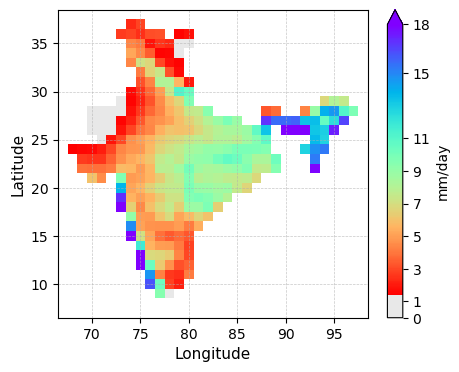

In [73]:
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust figure size and resolution
# Custom colorbar ticks and settings
ticks = [0, 1, 3, 5, 7, 9, 11, 15, 18]
cbar_kwargs = {
    'label': 'mm/day',
    'spacing': 'proportional',
    'format': '%.0f',  # No decimal values
    'ticks': ticks
}

# Use a custom colormap starting from light gray and transitioning through rainbow
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

# Create a new colormap that starts with light gray
n_colors = 256
rainbow = cm.get_cmap('rainbow_r', n_colors)
gray_to_rainbow = np.vstack((np.ones((20, 4)) * 0.9, rainbow(np.linspace(0, 1, n_colors - 20))))
custom_cmap = ListedColormap(gray_to_rainbow)

x_mmday = x_week34.mean('M').mean('T')
y_mask = y_week34.mean('T').isnull()
x_mmday = x_mmday.where(y_mask == 0, drop=False)
x_mmday.plot(
    vmin=0, vmax=18, cmap=custom_cmap,
    cbar_kwargs=cbar_kwargs, ax=ax
)

ax.set_xlabel("Longitude", fontsize=11)
ax.set_ylabel("Latitude", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.savefig(f'figures/{model}_{obs}/climo.pdf', dpi=300, bbox_inches='tight')

## ACC

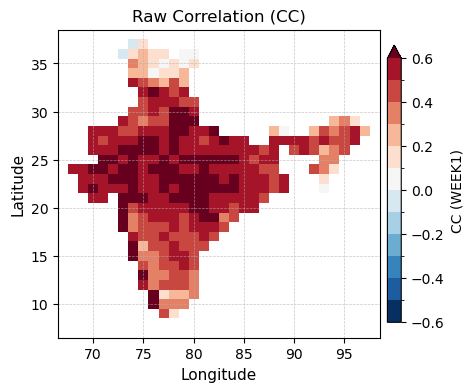

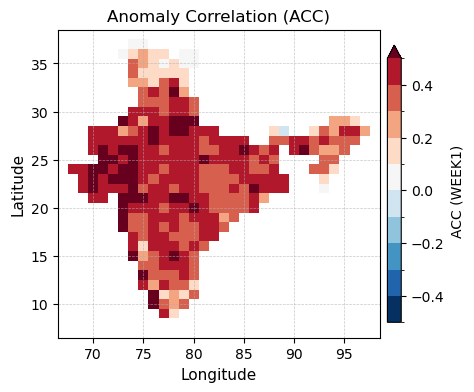

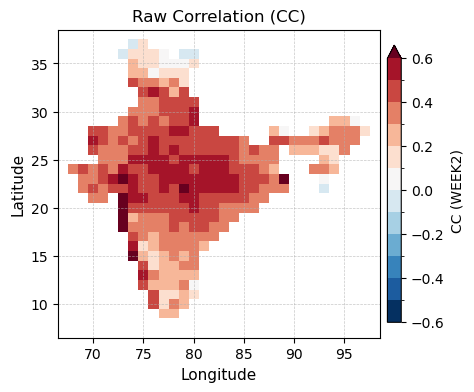

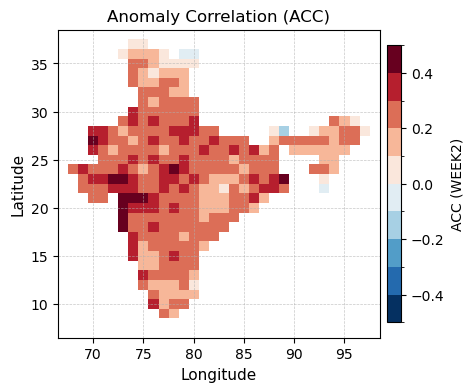

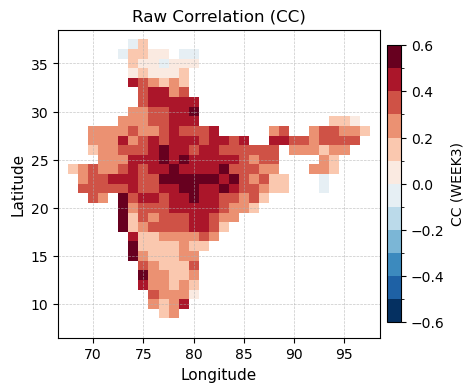

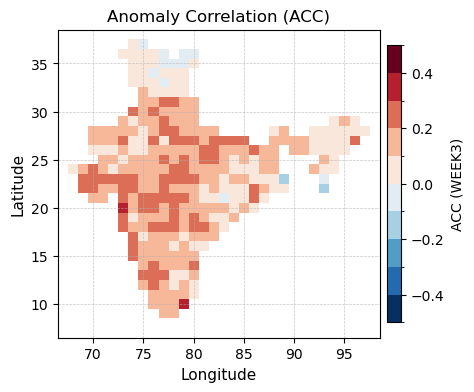

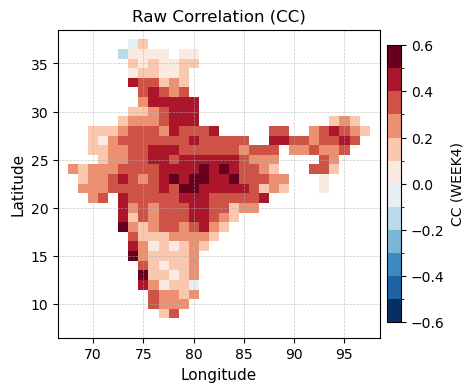

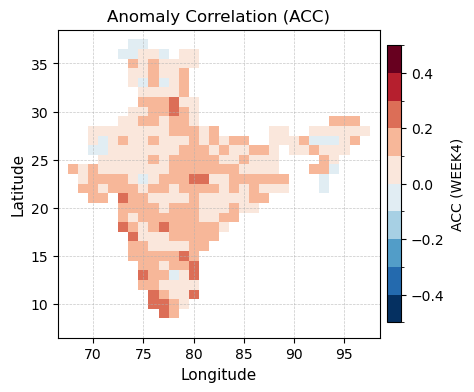

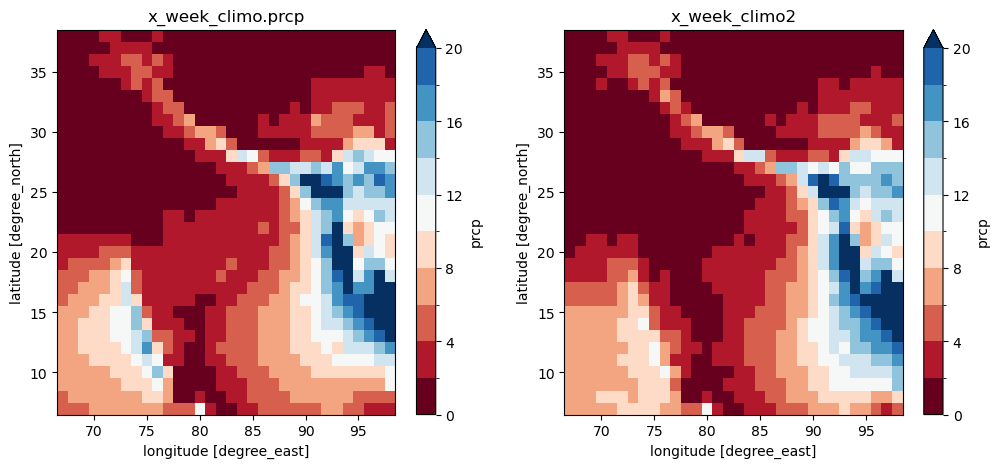

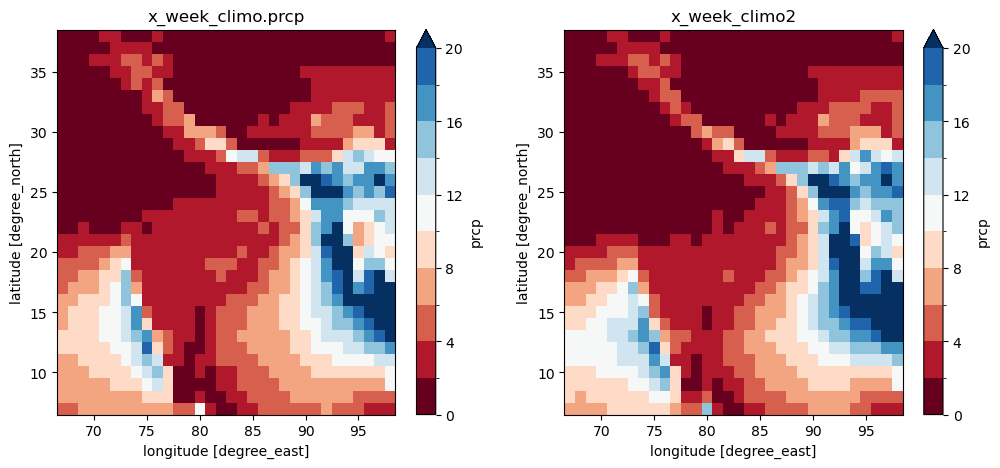

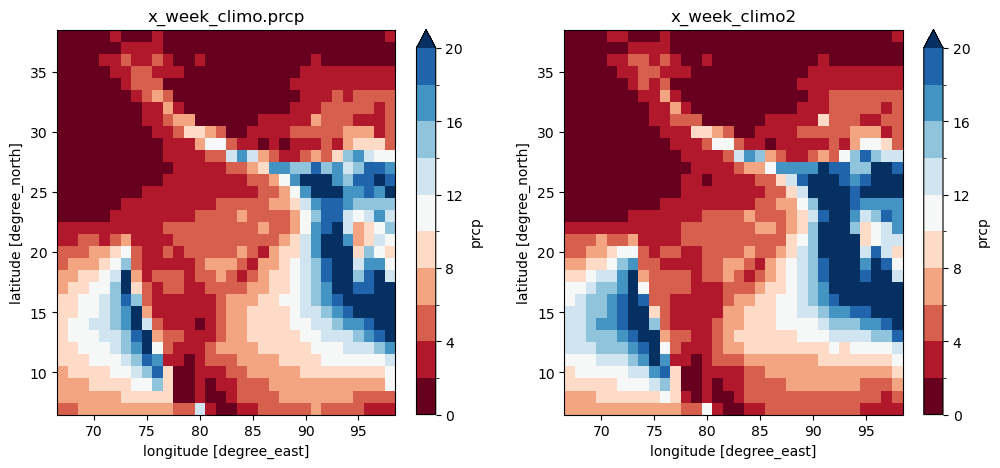

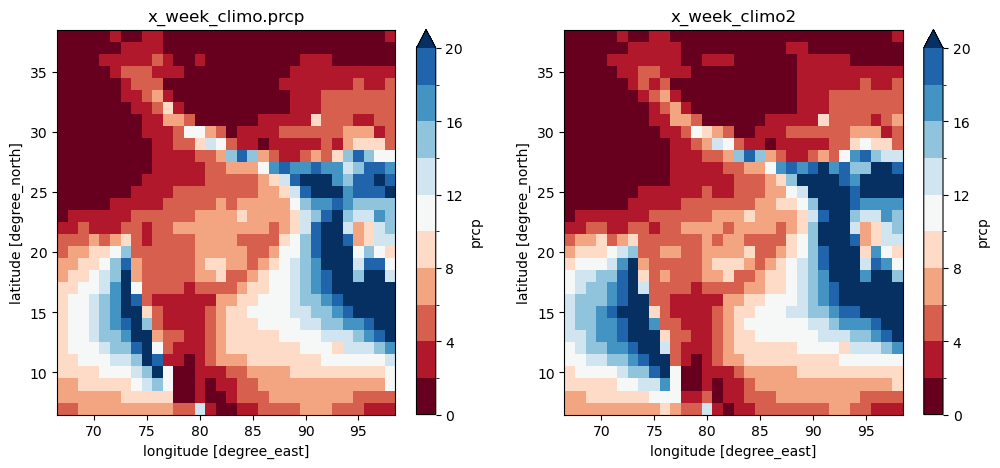

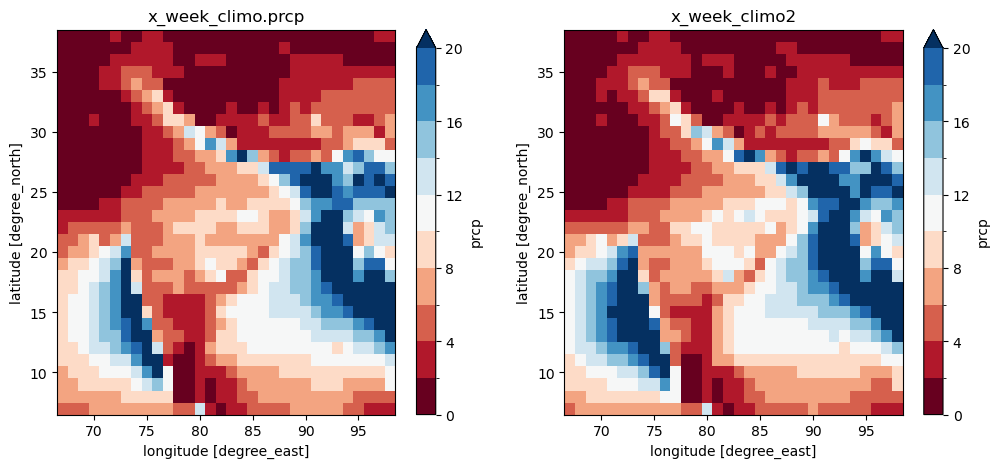

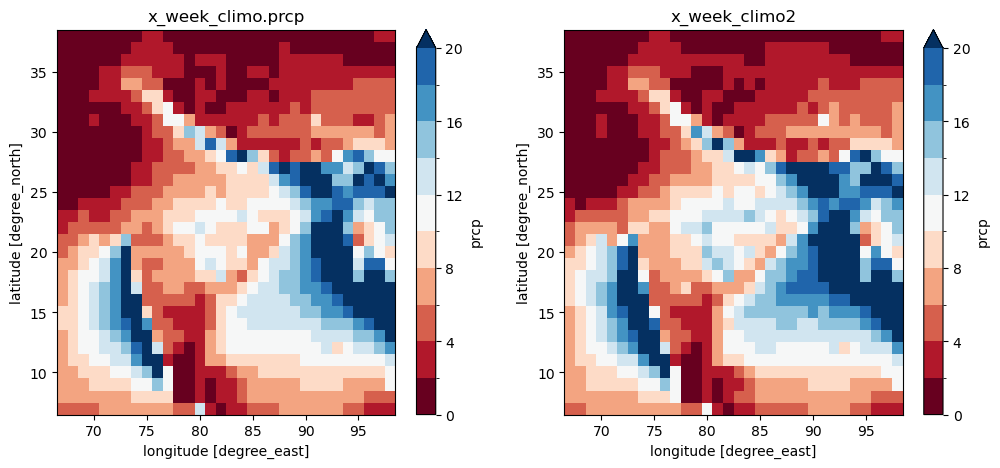

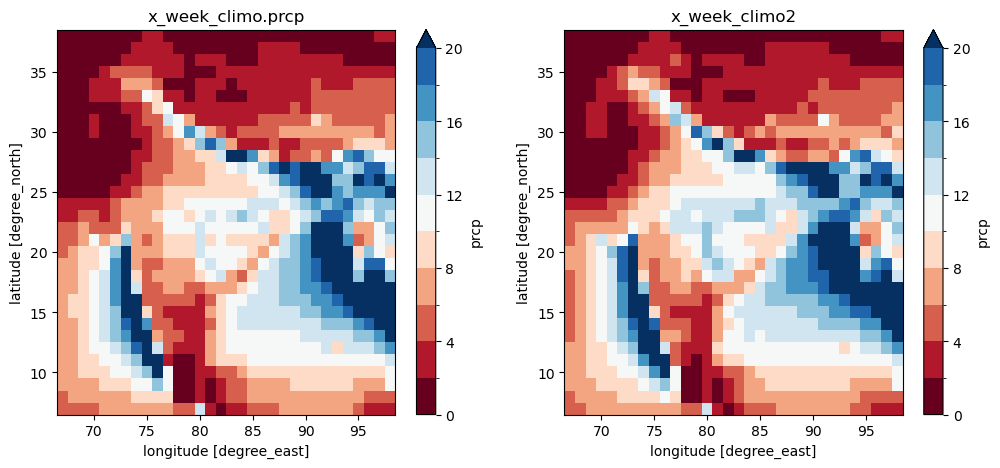

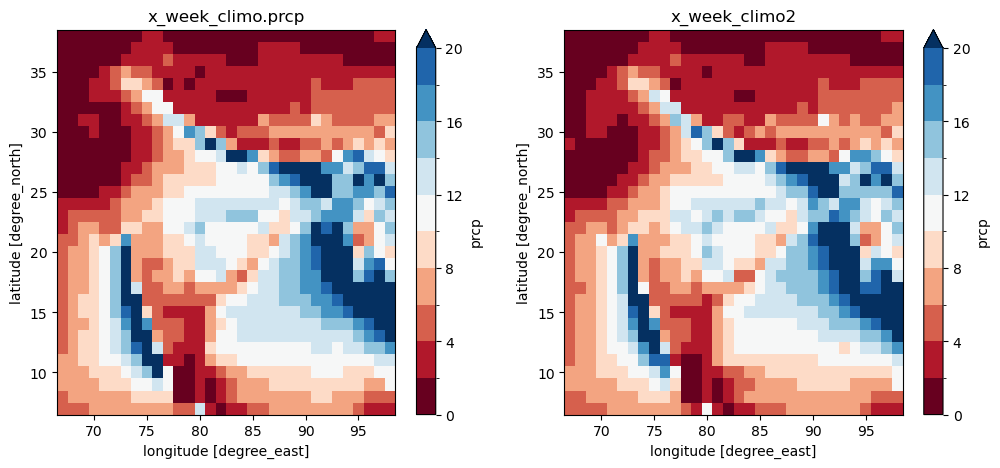

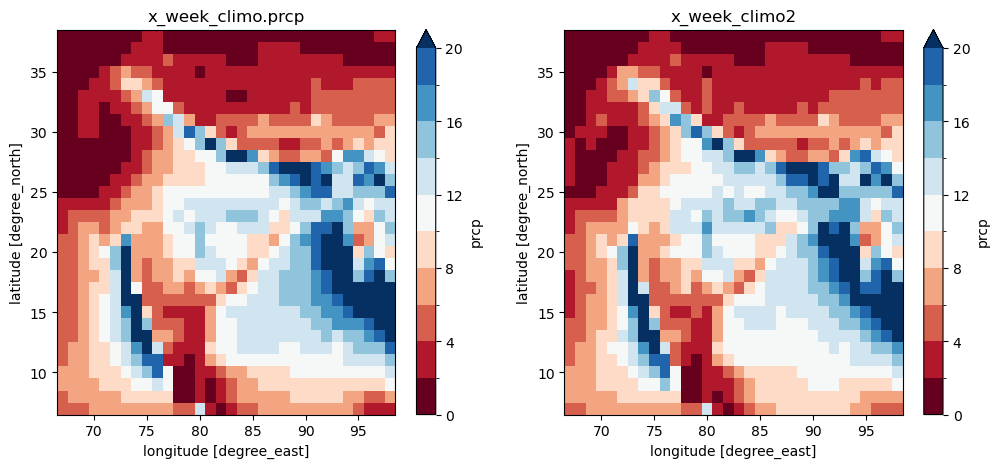

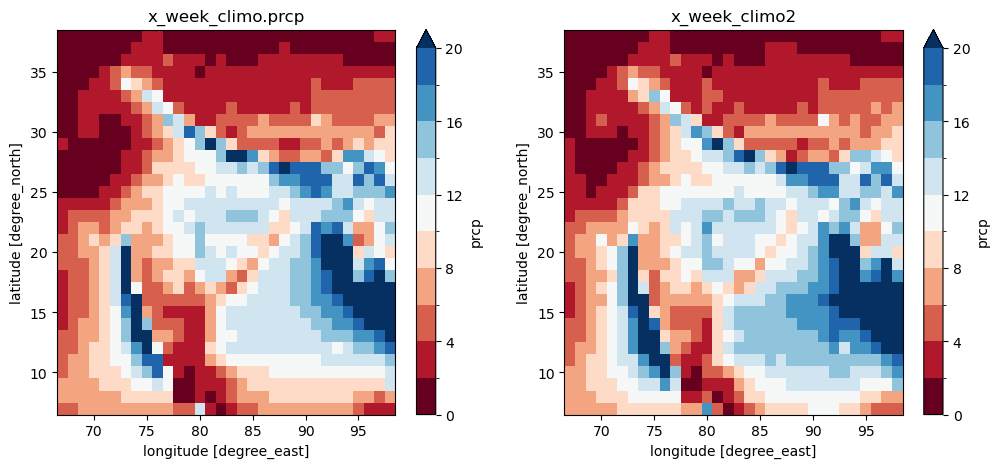

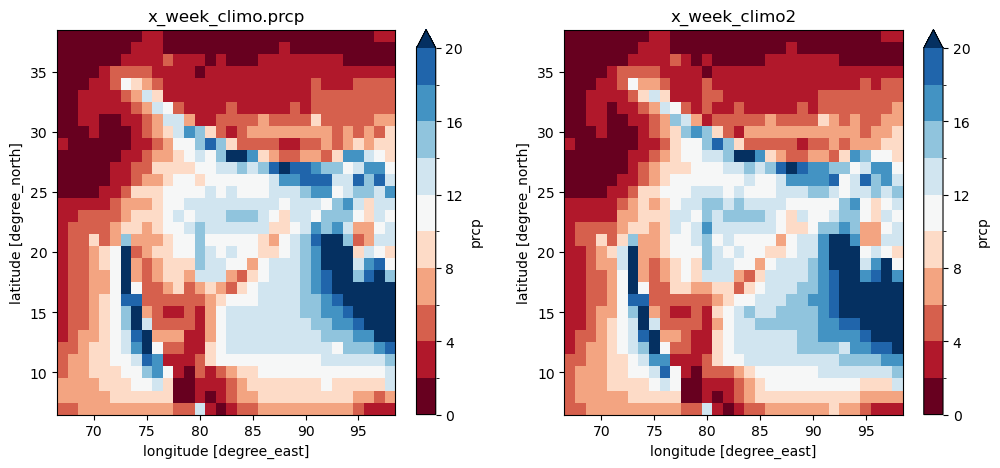

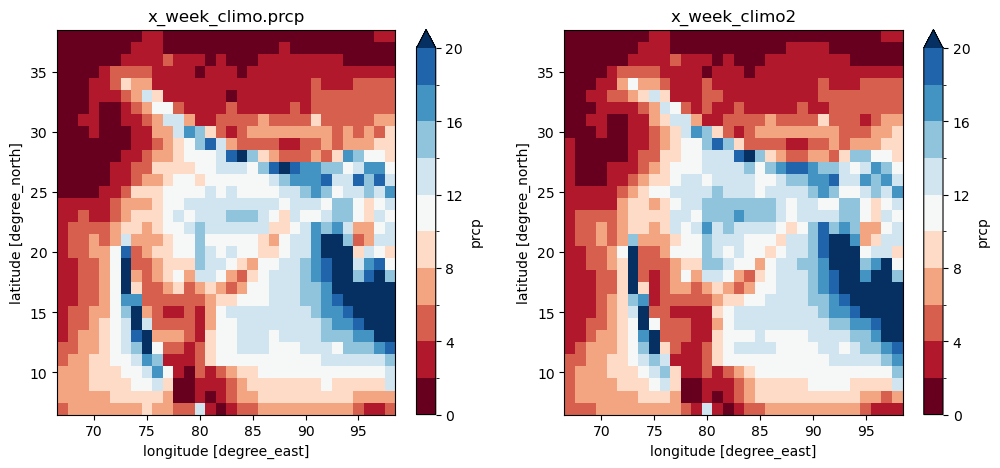

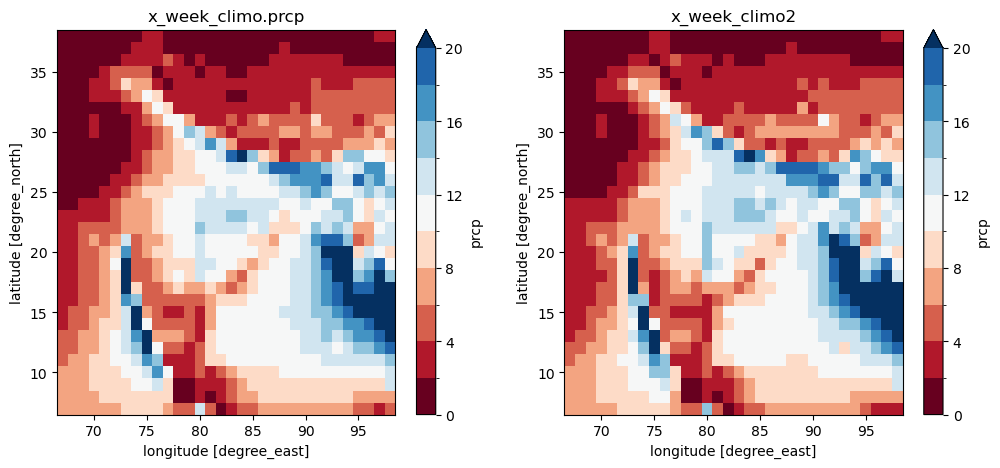

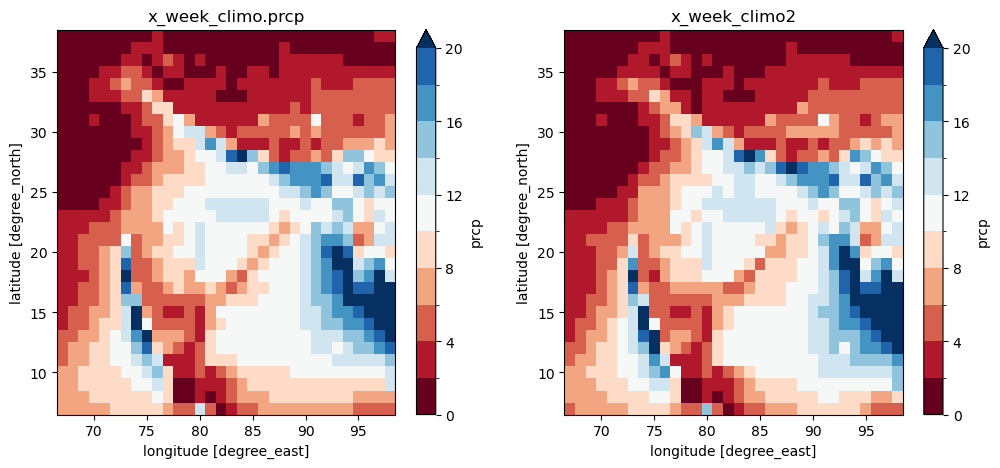

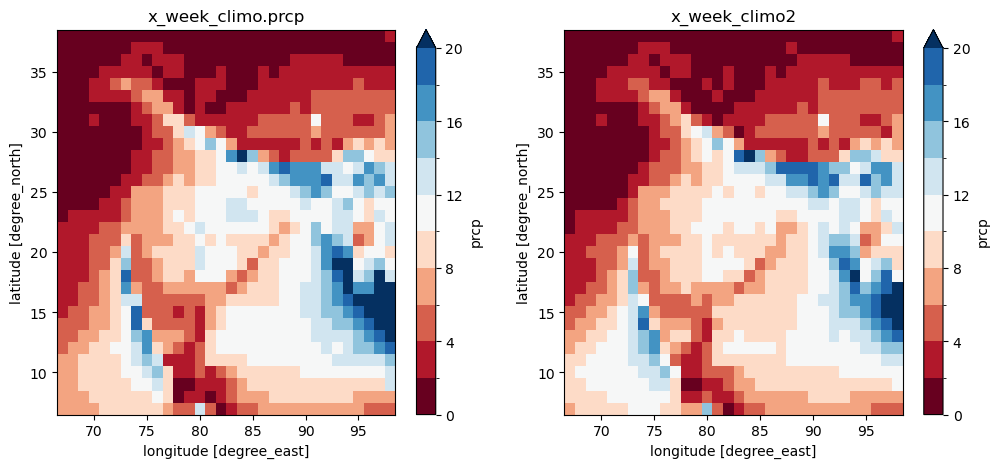

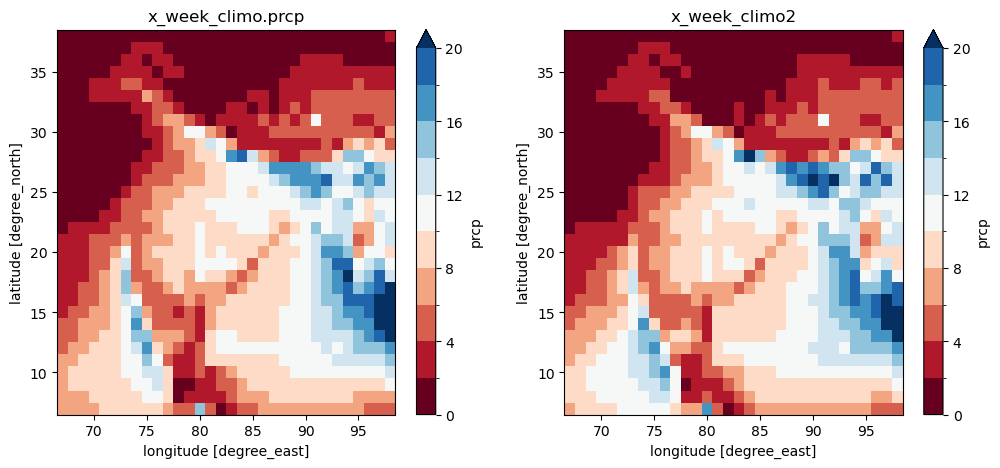

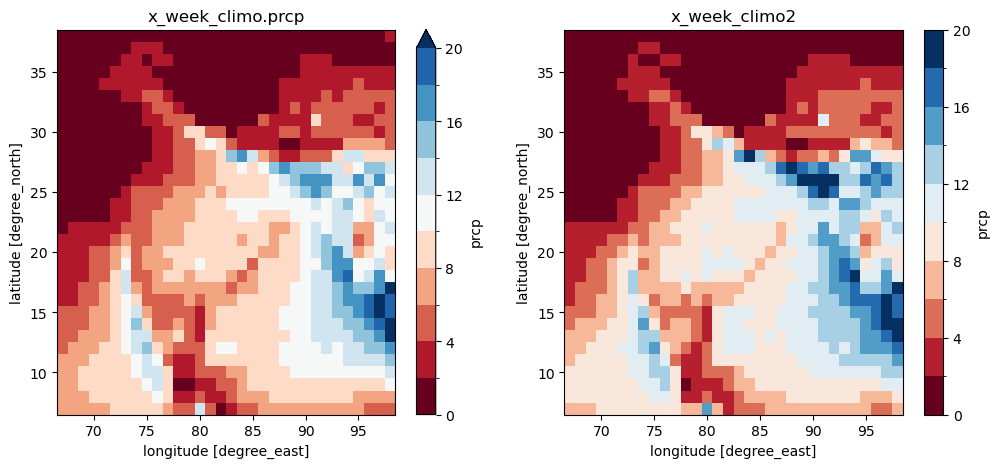

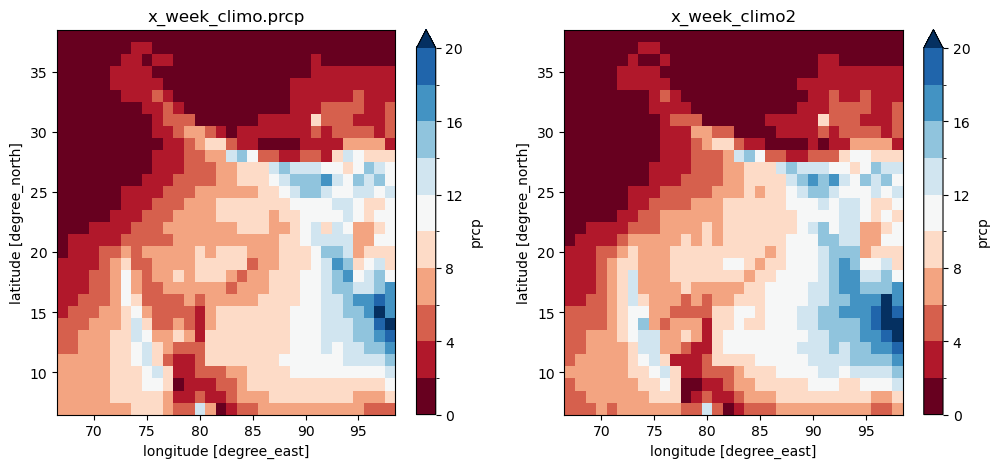

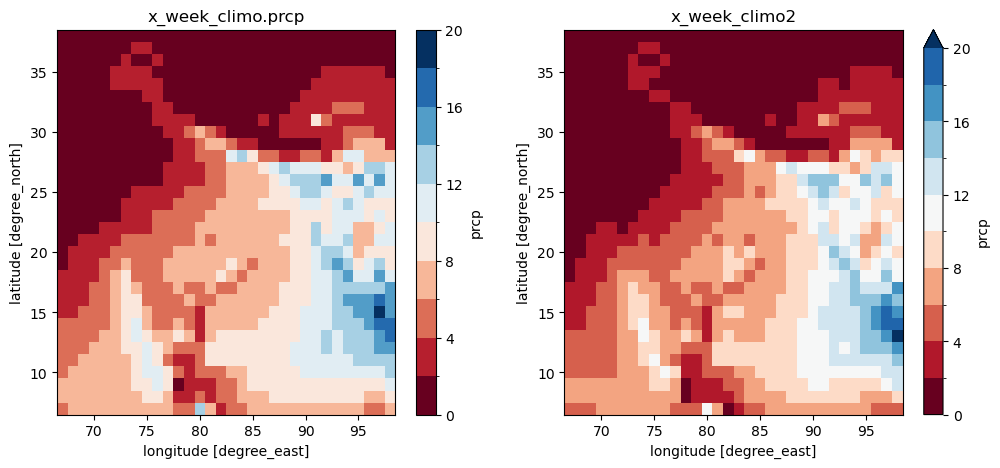

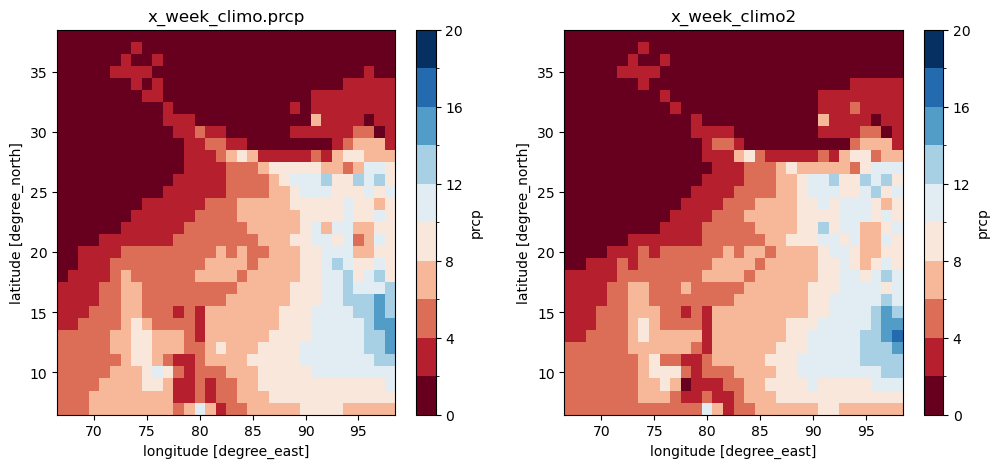

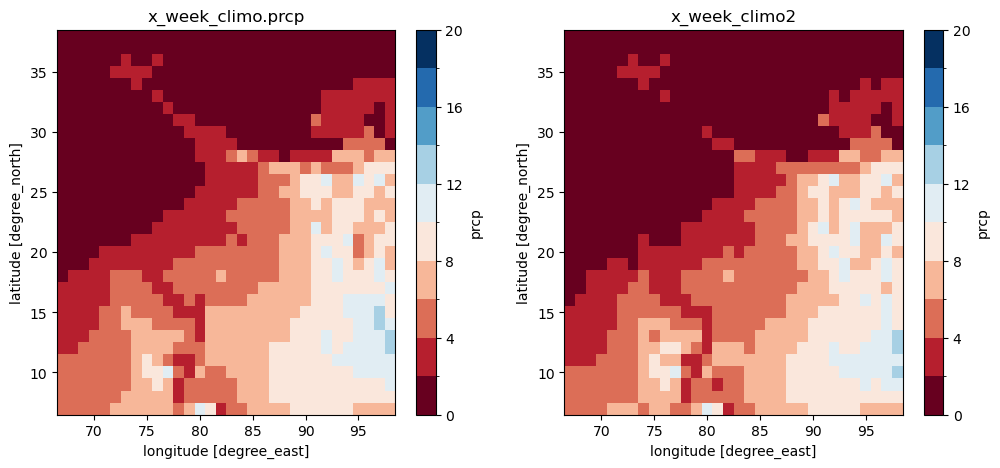

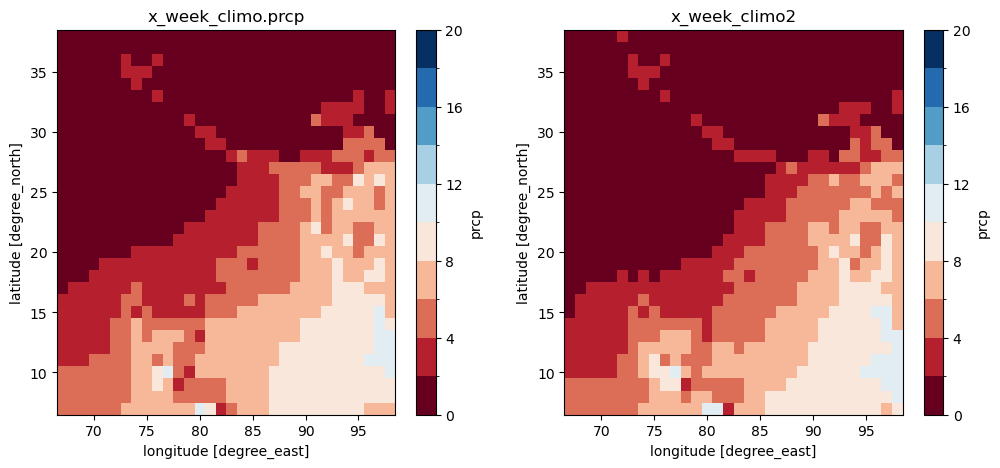

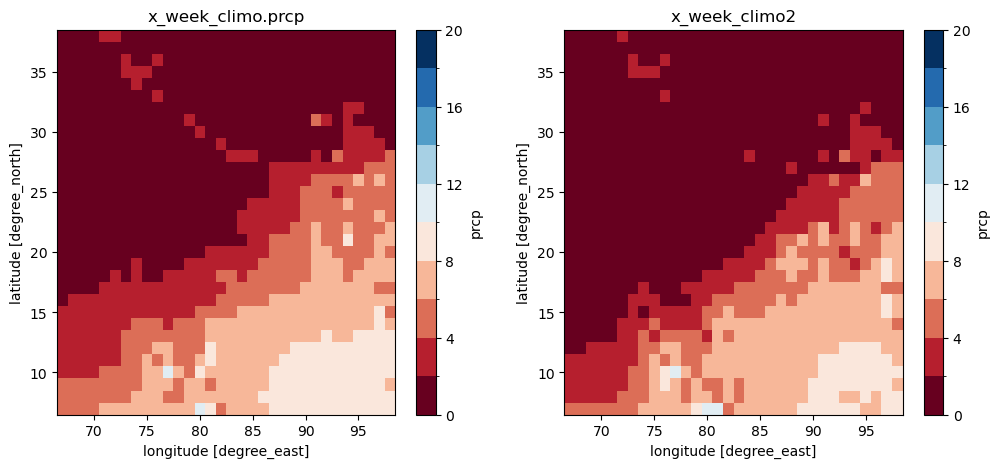

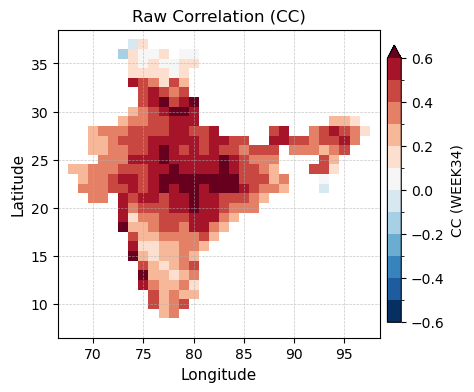

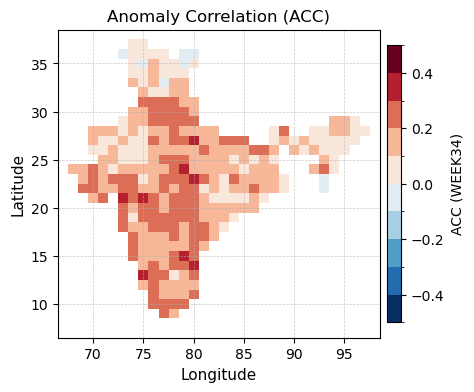

In [74]:
# Forecasts and observations by lead week
x_weeks = {
    "week1": x_week1,
    "week2": x_week2,
    "week3": x_week3,
    "week4": x_week4,
    "week34": x_week34
}

y_weeks = {
    "week1": y_week1,
    "week2": y_week2,
    "week3": y_week3,
    "week4": y_week4,
    "week34": y_week34
}

week_to_lead = {
    "week1": (2.5, 7.5),
    "week2": (9.5, 15.5),
    "week3": (16.5, 21.5),
    "week4": (22.5, 28.5),
    "week34": (16.5, 28.5)}

for week_name in x_weeks:
        
    x = x_weeks[week_name].mean('M')
    y = y_weeks[week_name]

    x_anom_list = []
    y_anom_list = []

    for week_i in set(x['T'].dt.week.values):
        # Subset by week number
        x_week_i = x.where(x['T'].dt.week == week_i, drop=True)
        y_week_i = y.where(y['T'].dt.week == week_i, drop=True)

                # Get month/day from the first time in x_week_i
        first_date = pd.Timestamp(x_week_i['S'].values[0])
        m = first_date.month
        d = first_date.day

        # Select the matching climatology day from gefs_climo
        x_week_climo = gefs_climo.sel(
            S=(gefs_climo['S'].dt.month == m) & (gefs_climo['S'].dt.day == d)
        ).sel(L=slice(week_to_lead[week_name][0], week_to_lead[week_name][1])).mean('L').mean('S')
        #rename the variable to 'prcp'
        x_week_climo = x_week_climo.rename({'pr': 'prcp'})

        x_week_climo2 = x_week_i.mean('T')

        #only for week34
        if week_name == "week34":
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # First plot
            x_week_climo.prcp.plot(cmap='RdBu', ax=axes[0], levels=11,vmax= 20, vmin=0)
            axes[0].set_title('x_week_climo.prcp')

            # Second plot
            x_week_climo2.plot(cmap='RdBu', ax=axes[1], levels=11,vmax= 20, vmin=0)
            axes[1].set_title('x_week_climo2')


            plt.show()

        # Use y mean for anomaly computation
        y_week_anom = y_week_i - y_week_i.mean('T')
        x_week_anom = x_week_i -  x_week_climo # x_week_i.mean('T')

        x_anom_list.append(x_week_anom)
        y_anom_list.append(y_week_anom)

    # Merge across week subsets
    x_anom = xr.merge(x_anom_list)['prcp'].sortby('T')
    y_anom = xr.merge(y_anom_list)['prcp'].sortby('T')


    # Compute anomaly correlation coefficient
    cc = xr.corr(x, y, dim='T')
    acc = xr.corr(x_anom, y_anom, dim='T')

    # Plotting
    # --- Plot CC ---
    fig, ax = plt.subplots(figsize=(5, 4))
    cc.plot(
        ax=ax,
        vmin=-0.4, vmax=0.4, cmap='RdBu_r',
        levels=[ -0.6, -0.5,-0.4,-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
        cbar_kwargs={
            'label': f'CC ({week_name.upper()})',
            'shrink': 0.9, 'pad': 0.02, 'orientation': 'vertical'
        }
    )
    ax.set_title("Raw Correlation (CC)", fontsize=12)
    ax.set_xlabel("Longitude", fontsize=11)
    ax.set_ylabel("Latitude", fontsize=11)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(f'figures/{model}_{obs}/CC_{week_name}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # --- Plot ACC ---
    fig, ax = plt.subplots(figsize=(5, 4))
    acc.plot(
        ax=ax,
        vmin=-0.4, vmax=0.4, cmap='RdBu_r',
        levels=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
        cbar_kwargs={
            'label': f'ACC ({week_name.upper()})',
            'shrink': 0.9, 'pad': 0.02, 'orientation': 'vertical'
        }
    )
    ax.set_title("Anomaly Correlation (ACC)", fontsize=12)
    ax.set_xlabel("Longitude", fontsize=11)
    ax.set_ylabel("Latitude", fontsize=11)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(f'figures/{model}_{obs}/ACC_{week_name}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()